In [1]:
### imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import timeit
from random import sample, setstate, getstate
import warnings
warnings.filterwarnings('ignore')

# Question


Our client has been under criticism because of their vehicle search policy. There's a suspicion of biases against groups of protected classes by the agents making the decision of searching or not a vehicle.

As part of our service of developing a model to help the agents deciding when or not to conduct a search we were ask to investigate and confirm the bias claims.  

In [2]:
### Load Data 

filename = 'Data/FairSearchData.csv'
fair_df = pd.read_csv(filename)
fair_df.head(10)

,Intervention DateTime,Department Name,Reporting Officer Identification ID,Subject Race Code,Subject Ethnicity Code,Subject Sex Code,Subject Age,Resident Indicator,Town Resident Indicator,Intervention Location Name,Intervention Reason Code,Statute Code Description,Vehicle Searched Indicator,Search Authorization Code,Contraband Indicator
0,2013-10-01 12:52:00-04:00,Branford,378.0,W,N,F,36.0,True,False,BRANFORD,V,Seatbelt,False,N,False
1,2013-10-01 14:38:00-04:00,State Police,1000001940.0,W,M,M,46.0,True,True,NEW HAVEN,V,Other,False,N,False
2,2013-10-01 20:25:00-04:00,State Police,1000002349.0,W,H,F,33.0,True,False,NORWICH,V,Seatbelt,False,N,False
3,2013-10-01 02:11:00-04:00,State Police,987312802.0,B,N,M,64.0,True,False,OLD SAYBROOK,V,Other,False,N,False
4,2013-10-01 09:35:00-04:00,Branford,1051.0,W,N,M,49.0,True,True,Branford,I,Display of Plates,False,N,False
5,2013-10-01 09:49:00-04:00,Ridgefield,1000142.0,B,N,M,18.0,True,False,RIDGEFIELD,V,Speed Related,False,N,False
6,2013-10-01 14:23:00-04:00,Torrington,NaN,W,N,M,49.0,True,False,Torrington,V,Cell Phone,False,N,False
7,2013-10-01 01:31:00-04:00,State Police,961269420.0,W,N,M,26.0,False,False,EAST HAVEN,V,Speed Related,False,N,False
8,2013-10-01 15:41:00-04:00,Manchester,NaN,W,N,F,31.0,True,False,Manchester,V,Cell Phone,False,N,False
9,2013-10-01 20:35:00-04:00,Ridgefield,1000064.0,W,N,F,20.0,True,False,Ridgefield,V,Speed Related,False,N,False


## Data Set  

The data set is comprised of 841908 observations collected during stop operations. Each observation is characterized using 16 features.

#### The features are: 

- **Vehicle Searched Indicator:** Wheter the vehicle was searched
- **Contraband Indicator:** Was contraband found
- **Department Name:** Name of the police department where the intervention was registered
- **Intervention DateTime:** Date and time of the intervention
- **Intervention Location Name:** Location of the intervention
- **Intervention Reason Code:** Code of the reason given for stopping the vehicle -> I: Investigation ; V: Violation ; E: Equipment 
- **Reporting Officer Indentification ID:** Identification, ID, of the officer who reported the intervention 
- **Resident Indicator:** whether the subject was a resident of the state 
- **Search Authorization Code:** Authority to search vehicle -> N: Not Applicable ; C: Consent ; I: Inventory ; O/Other: Probable Cause, Reasonable Suspicion, Plain View Contraband, Incident to Arrest, Drug Dog Alert, Exigent Circunstances
- **Statute Reason:** Reason given for stopping the car
- **Subject Age:** Age of the main occupier of the vehicle
- **Subject Etnicity Code:** Officer perception of the ethnicity of the subject
- **Subject Race Code:** Officer perception of the ethnicity of the subject
- **Subject Sex Code:** Officer perception of the sex of the subject
- **Town Resident Indicator:** Wheter the subject was a resident of the town





#### Let's get some more information about these features:  

In [3]:
### Look at DF columns data types and null values

#data types and null values
print(fair_df.info(verbose = True, null_counts = True))

print('\n')
print('\n')
print('Quantification of null values')
print('\n')

#detail of null values
print(fair_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915611 entries, 0 to 2915610
Data columns (total 15 columns):
 #   Column                               Non-Null Count    Dtype 
---  ------                               --------------    ----- 
 0   Intervention DateTime                2915611 non-null  object
 1   Department Name                      2915611 non-null  object
 2   Reporting Officer Identification ID  2786134 non-null  object
 3   Subject Race Code                    2915611 non-null  object
 4   Subject Ethnicity Code               2915611 non-null  object
 5   Subject Sex Code                     2915611 non-null  object
 6   Subject Age                          2915507 non-null  object
 7   Resident Indicator                   2915610 non-null  object
 8   Town Resident Indicator              2915604 non-null  object
 9   Intervention Location Name           2915574 non-null  object
 10  Intervention Reason Code             2915611 non-null  object
 11  Statute Cod

#### Null Values

With the exception of the feature 'Reporting Officer Identification ID' the data set is quite complete, with the second feature with most null values - "Subject Age" - having 104 (0.0008% of the total observations).

Given the sistemic nature of the client's requests the identity of the individual officers is not a usefull indicator and the feature will be dropped. After doing so we were left with so few null values per column that we decide just to drop the rows with at least one null value. 


#### Data Types

All features have been imported with data type object. Upon observation of the different features we decided to:

- **Transform "Intervention DateTime" into datetime format**  
- **Trasform into boolean variables all True/False features**
- **Transform into integer the "Subject Age" feature**
- **To avoid possible duplication issues turn into str and lower case all string features**
- **For the same reason we will also get rid of spaces in all string features**

Before these transformations we have some cleaning to do namely in the "Subject Age" feature. 


In [4]:
### Drop "Reporting Officer Identification ID" and null Values 

#drop Reporting Officer Identification ID
fair_df.drop('Reporting Officer Identification ID', axis = 1, inplace = True)

#drop Null Values
orig_observ = fair_df.shape[0]
fair_df = fair_df.dropna()
no_null_observ = fair_df.shape[0]

In [5]:
### Change Data Type of "Subject Age" feature

#before changing the feature data type we have to get rid of some rows where "Subject Age" has non numeric values
numbers_filter = fair_df['Subject Age'].astype('str').str.contains('^[1-9]\d*(\.\d+)?$')
fair_df = fair_df[numbers_filter].copy()

#change data type 
fair_df['Subject Age'] = fair_df['Subject Age'].astype('float').astype('int').copy()


In [6]:
### Change Data Types and Capitalization

#In the True or False columns the feature values show up in different ways: as booleans True/False and as
#strings 'True','False','1','0'. We need to take this into consideration.
bool_clmns = ['Resident Indicator','Town Resident Indicator','Vehicle Searched Indicator','Contraband Indicator']
d = {'True': True, '1': True, 'False': False, '0': False}
fair_df[bool_clmns]=fair_df[bool_clmns].apply(lambda x: x.astype('str').map(d))


#change data types
bool_clmns = ['Resident Indicator','Town Resident Indicator','Vehicle Searched Indicator','Contraband Indicator']
fair_df['Intervention DateTime'] = pd.to_datetime(fair_df['Intervention DateTime'],utc=True).dt.tz_localize(None)


#capitalization and spaces
all_clmns = fair_df.columns
extra_clmns = bool_clmns
extra_clmns.extend(['Subject Age', 'Intervention DateTime'])
lower_clmns = np.setdiff1d(all_clmns,extra_clmns)
fair_df[lower_clmns] = fair_df[lower_clmns].apply(lambda x: x.astype(str).str.lower().str.replace(' ',''))

# Check the results
fair_df.info()

print('\n')
'The dataset columns have now the desired data type and capitalization and we got rid '\
f'of the null values loosing {orig_observ - no_null_observ} observations, '\
f'{np.round((orig_observ - no_null_observ) / orig_observ * 100,3)}% of the original total.'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2908155 entries, 0 to 2915610
Data columns (total 14 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Intervention DateTime       datetime64[ns]
 1   Department Name             object        
 2   Subject Race Code           object        
 3   Subject Ethnicity Code      object        
 4   Subject Sex Code            object        
 5   Subject Age                 int64         
 6   Resident Indicator          bool          
 7   Town Resident Indicator     bool          
 8   Intervention Location Name  object        
 9   Intervention Reason Code    object        
 10  Statute Code Description    object        
 11  Vehicle Searched Indicator  bool          
 12  Search Authorization Code   object        
 13  Contraband Indicator        bool          
dtypes: bool(4), datetime64[ns](1), int64(1), object(8)
memory usage: 255.2+ MB




'The dataset columns have now the desired data type and capitalization and we got rid of the null values loosing 153 observations, 0.005% of the original total.'

## Representation of groups in protected classes

Given that the qestion we were asked is related with protected classes' groups let's take a look at how these are represented in the dataset.

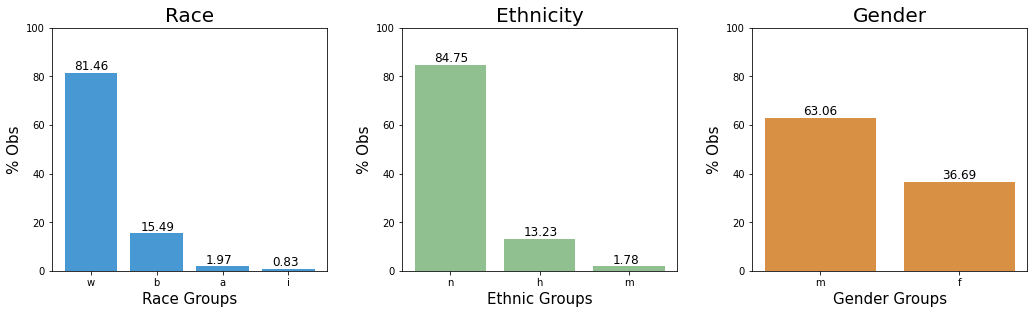

In [7]:
### Calculate and plot observation per proteted class groups

## Get observations

#race
race = fair_df['Subject Race Code'].value_counts()
r_labels = race.keys().tolist()
r_counts = race.tolist()

#ethnicity
ethnicity = fair_df['Subject Ethnicity Code'].value_counts()
e_labels = ethnicity.keys().tolist()
e_counts = ethnicity.tolist()

#gender
gender = fair_df['Subject Sex Code'].value_counts()
g_labels = gender.keys().tolist()
g_counts = gender.tolist()


## Plot observations 


#define fig and subplots
fig,axs = plt.subplots(1, 3, figsize=(15,5)) # De

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12


#plot race results
y0 = [x / no_null_observ * 100 for x in r_counts]
axs[0].bar(r_labels,y0,color=['#4899D3'])
axs[0].set_xlabel('Race Groups',fontsize = l_font)
axs[0].set_ylabel('% Obs',fontsize = l_font)
axs[0].set_title('Race',fontsize = t_font)
axs[0].set_ylim([0, 100])

for i, v in enumerate(y0): # place values on top of bars
    axs[0].text(i - 0.25, v + 1.2, str(np.round(v,2)),fontsize = txt_font)


#plot ethnicity results    
y1 = [x / no_null_observ * 100 for x in e_counts]
axs[1].bar(e_labels,y1,color=['#91C090'])
axs[1].set_xlabel('Ethnic Groups',fontsize = l_font)
axs[1].set_ylabel('% Obs',fontsize = l_font)
axs[1].set_title('Ethnicity',fontsize = t_font)
axs[1].set_ylim([0, 100])

for i, v in enumerate(y1): # place values on top of bars
    axs[1].text(i - 0.18, v + 1.2, str(np.round(v,2)),fontsize = txt_font)


#plot gender results    
y2 = [x / no_null_observ * 100 for x in g_counts]    
axs[2].bar(g_labels,y2,color=['#D79044'])
axs[2].set_xlabel('Gender Groups', fontsize = l_font)
axs[2].set_ylabel('% Obs',fontsize = l_font)
axs[2].set_title('Gender',fontsize = t_font)
axs[2].set_ylim([0, 100])

for i, v in enumerate(y2): # place values on top of bars
    axs[2].text(i - 0.12, v + 1.2, str(np.round(v,2)),fontsize = txt_font)


fig.tight_layout(pad=3.0)

plt.show()


**Race:** w - white; b - Black; a - asian; i - indian

**Ethnicity:** n - no ethnicity; h: hispanic; m: middle eastener

**Gender:** m - male; f - female

Observation of the plots allows us to understand that our data set is quite unbalanced in terms of the representation of the different groups.

Some groups have very little observations:

- Race:
    - Asian: 1.07%
    - Indian: 0.83%
    
    
- Ethnicity:
    - middle-easterner: 1.78%
    

Given the low numbers (bear in mind that the number of vehicles searched and contraband found would still be a smaller fraction of the observations) the impact of these groups on our general problem would be very small and noisy. Because this was a first approach, and there was no specific request about which groups to include, we decided to simplify our task an drop these under-represented groups.
   


In [8]:
### Drop under-represented groups

#drop under-represented groups
fair_df = fair_df[(fair_df['Subject Race Code'] != 'a') & (fair_df['Subject Race Code'] != 'i') & (fair_df['Subject Ethnicity Code'] != 'm')].copy()


# Investigate biases in vehicle search policy

We are now going to look for protected classes related biases on the decision to search or not a stopped vehicle 


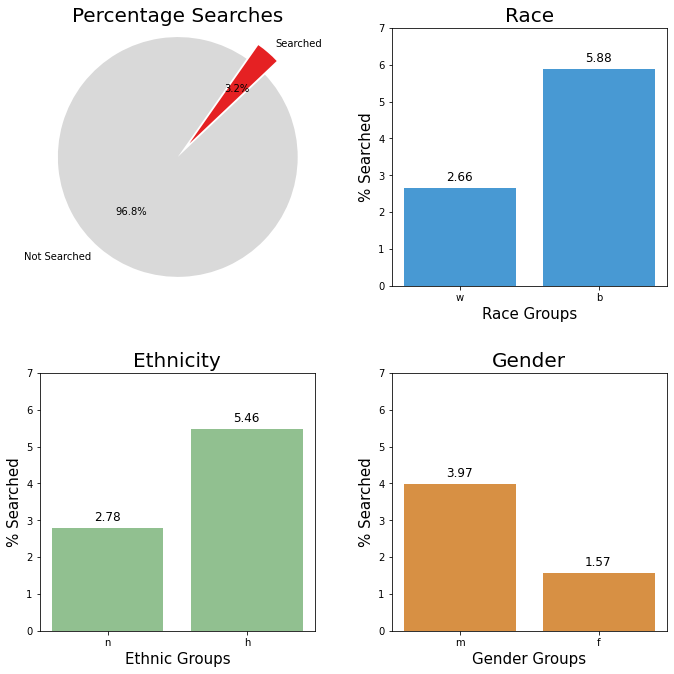

In [9]:
###Plot percentage of searched vehicles per protected group. 

## Get and organize data to plot

#total percentage of searched vehicles 
total = fair_df['Vehicle Searched Indicator'].value_counts()
t_labels = ['Not Searched','Searched']
t_counts = total.tolist()


#percentage of searched vehicles by race 
race_obs = r_counts[0:2] # obs for h and b race groups

race_s = fair_df[fair_df['Vehicle Searched Indicator'] == True]['Subject Race Code'].value_counts()
rs_labels = race_s.keys().tolist()
rs_counts = race_s.tolist()


#percentage of searched vehicles by ethnic group 
ethnicity_obs = e_counts[0:2] # obs for h and b race groups

ethnicity_s = fair_df[fair_df['Vehicle Searched Indicator'] == True]['Subject Ethnicity Code'].value_counts()
es_labels = ethnicity_s.keys().tolist()
es_counts = ethnicity_s.tolist()


#percentage of searched vehicles by ethnic group 
gender_obs = g_counts[0:2] # obs for h and b race groups

gender_s = fair_df[fair_df['Vehicle Searched Indicator'] == True]['Subject Sex Code'].value_counts()
gs_labels = gender_s.keys().tolist()
gs_counts = gender_s.tolist()

## Plot 


#define fig and subplots
fig,axs = plt.subplots(2, 2, figsize=(10,10))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12


#plot total results
y0 = t_counts
axs[0,0].pie(y0,labels = t_labels,explode = (0,0.15), autopct='%1.1f%%',shadow=False, startangle=55,colors=['#D9D9D9','#E52123'])
axs[0,0].set_title('Percentage Searches',fontsize = t_font)
axs[0,0].axis('equal')


#plot race results
y1 = [rs_counts[0]/race_obs[0]*100,rs_counts[1]/race_obs[1]*100]
axs[0,1].bar(rs_labels,y1,color=['#4899D3'])
axs[0,1].set_xlabel('Race Groups',fontsize = l_font)
axs[0,1].set_ylabel('% Searched',fontsize = l_font)
axs[0,1].set_title('Race',fontsize = t_font)
axs[0,1].set_ylim([0, 7])

for i, v in enumerate(y1): # place values on top of bars
    axs[0,1].text(i - 0.1, v + 0.2, str(np.round(v,2)),fontsize = txt_font)
    

#plot ethnicity results    
y2 = [es_counts[0]/ethnicity_obs[0]*100,es_counts[1]/ethnicity_obs[1]*100]
axs[1,0].bar(es_labels,y2,color=['#91C090'])
axs[1,0].set_xlabel('Ethnic Groups',fontsize = l_font)
axs[1,0].set_ylabel('% Searched',fontsize = l_font)
axs[1,0].set_title('Ethnicity',fontsize = t_font)
axs[1,0].set_ylim([0, 7])

for i, v in enumerate(y2): # place values on top of bars
    axs[1,0].text(i - 0.1, v + 0.2, str(np.round(v,2)),fontsize = txt_font)
    
      
# Plot gender results 
y3 = [gs_counts[0]/gender_obs[0]*100,gs_counts[1]/gender_obs[1]*100]
axs[1,1].bar(gs_labels,y3,color=['#D79044'])
axs[1,1].set_xlabel('Gender Groups',fontsize = l_font)
axs[1,1].set_ylabel('% Searched',fontsize = l_font)
axs[1,1].set_title('Gender',fontsize = t_font)
axs[1,1].set_ylim([0, 7])

for i, v in enumerate(y3): # place values on top of bars
    axs[1,1].text(i - 0.1, v + 0.2, str(np.round(v,2)),fontsize = txt_font)

    
    
    
fig.tight_layout(pad=3.0)

plt.show()    

## Biases in vehicle search policy results

The first noticeable thing is that only a very small percentage (3.2%) of the stopped vehicles are subjected to a search. The second is that there are very evident differences in the percentage of searches ordered within the groups of the different protected classes:

- The percentage of stopped vehicles, drove by black peple, that are searched more than doubles the one of vehicles drove by white individuals. 

- The same is true for the ethnicity protected group, with the percentage of searched vehicles drove by hispanics being 1.96 times higher than the one of individuals with no perceived ethnic background. 

- In the gender group the percentage of male drivers that see their vehicles searched more than doubles the percentage of searches in vehicles drove by women. 


# Investigate contraband found in protected classes

The differences shown above reveal that the decision to search, or not, a stopped vehicle seems to be biased towards certain groups within each protected class. Let's now look at the contraband found to see if this behavior has any practical justification.

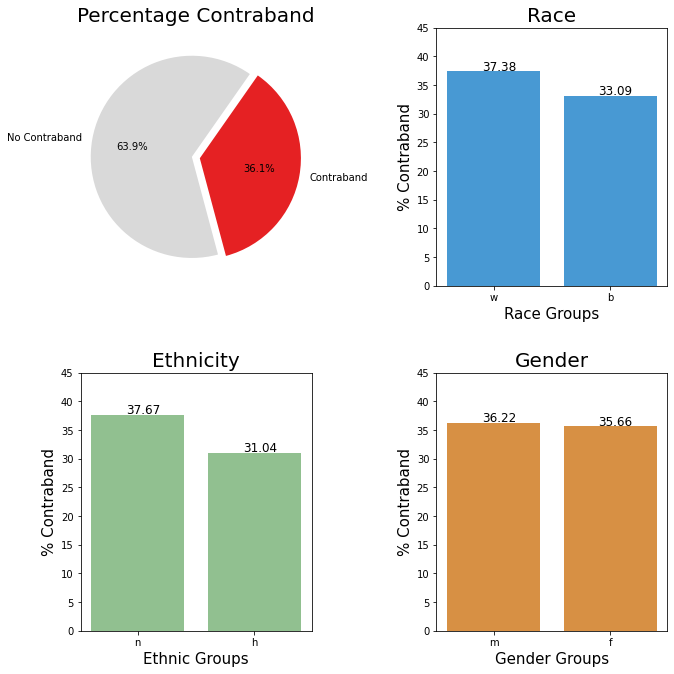

In [10]:
### Plot percentage of searched vehicles with contraband per protected class group. 

## Get and organize data to plot

#total percentage of contraband vehicles 
total_c = fair_df[fair_df['Vehicle Searched Indicator'] == True]['Contraband Indicator'].value_counts()
tc_labels = ['No Contraband','Contraband']
tc_counts = total_c.tolist()


#percentage of searched vehicles by race 
race_c = fair_df[fair_df['Contraband Indicator'] == True]['Subject Race Code'].value_counts()
rc_labels = race_c.keys().tolist()
rc_counts = race_c.tolist()


#percentage of searched vehicles by ethnic group 
ethnicity_c = fair_df[fair_df['Contraband Indicator'] == True]['Subject Ethnicity Code'].value_counts()
ec_labels = ethnicity_c.keys().tolist()
ec_counts = ethnicity_c.tolist()


#percentage of searched vehicles by ethnic group 
gender_obs = g_counts[0:2] # obs for h and b race groups

gender_c = fair_df[fair_df['Contraband Indicator'] == True]['Subject Sex Code'].value_counts()
gc_labels = gender_c.keys().tolist()
gc_counts = gender_c.tolist()



## Plot 


#define fig and subplots
fig,axs = plt.subplots(2, 2, figsize=(10,10))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12

#plot total results
y0 = tc_counts
axs[0,0].pie(y0,labels = tc_labels,explode = (0,0.08), autopct='%1.1f%%',shadow=False, startangle=55,colors=['#D9D9D9','#E52123'])
axs[0,0].set_title('Percentage Contraband',fontsize = t_font)
axs[0,0].axis('equal')


#plot race results
y1 = [rc_counts[0]/rs_counts[0]*100,rc_counts[1]/rs_counts[1]*100]
axs[0,1].bar(rc_labels,y1,color=['#4899D3'])
axs[0,1].set_xlabel('Race Groups',fontsize = l_font)
axs[0,1].set_ylabel('% Contraband',fontsize = l_font)
axs[0,1].set_title('Race',fontsize = t_font)
axs[0,1].set_ylim([0, 45])

for i, v in enumerate(y1): # place values on top of bars
    axs[0,1].text(i - 0.1, v + 0.2, str(np.round(v,2)),fontsize = txt_font)
    
    

#plot ethnicity results     
y2 = [ec_counts[0]/es_counts[0]*100,ec_counts[1]/es_counts[1]*100]
axs[1,0].bar(ec_labels,y2,color=['#91C090'])
axs[1,0].set_xlabel('Ethnic Groups',fontsize = l_font)
axs[1,0].set_ylabel('% Contraband',fontsize = l_font)
axs[1,0].set_title('Ethnicity',fontsize = t_font)
axs[1,0].set_ylim([0, 45])

for i, v in enumerate(y2): # place values on top of bars
    axs[1,0].text(i - 0.1, v + 0.2, str(np.round(v,2)),fontsize = txt_font)
    
    
#plot gender results 
y3 = [gc_counts[0]/gs_counts[0]*100,gc_counts[1]/gs_counts[1]*100]
axs[1,1].bar(gc_labels,y3,color=['#D79044'])
axs[1,1].set_xlabel('Gender Groups',fontsize = l_font)
axs[1,1].set_ylabel('% Contraband',fontsize = l_font)
axs[1,1].set_title('Gender',fontsize = t_font)
axs[1,1].set_ylim([0, 45])

for i, v in enumerate(y3): # place values on top of bars
    axs[1,1].text(i - 0.1, v + 0.2, str(np.round(v,2)),fontsize = txt_font)

    
    
    
fig.tight_layout(pad=3.0)

plt.show()    

## Contraband found in protected classes results

Contranband was found in 36% of the searched vehicles. Interestingly, the biases shown above, in the percentage of searched vehicles, are not supported by the contraband found. Both in the race and ethnicity classes there was a smaller percentage of contraband found in the groups with a higher percentage of searched vehicles: 4.29 p.p. less contraband found in vehicles drove by black individuals, and 6.63 p.p. less contraband found in vehicles drove by hispanics. In the gender group, despite a very marginal higher percentage of contrabans found in vehicles drove by men (+0.56 p.p.), the difference is much smaller than the one in searches: 2.6 times higher percentage of searches vs. 1.02 times higher percentage of contraband found. 

Together these allow us to conclude that there is a problem in the way police officers decide to conduct searches, with the presence of clear biases agains certain groups within protected classes. 

# Biases in the different departments

Are these trends common to all departments, are some departments more problematic than other? Let's first take a look at the distribution of observations per department. 


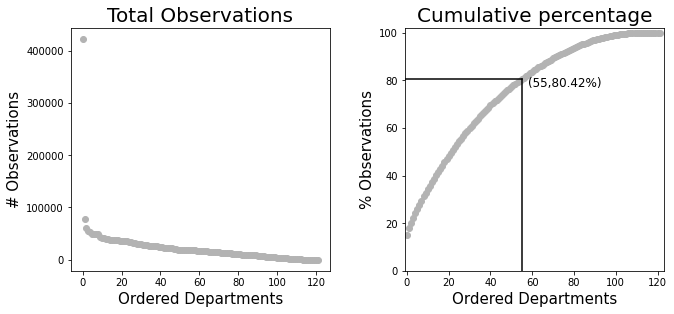

In [11]:
### Observation per department

## Get and organize data to plot
obs_dpt = fair_df['Department Name'].value_counts()
dpt_counts = obs_dpt.tolist()
dpt_cumsum = np.array((obs_dpt.cumsum()/obs_dpt.sum()*100))
dpt_numbers = list(range(len(dpt_counts)))
dpt_names = obs_dpt.keys().tolist()

x_vline = np.where(dpt_cumsum >= 80)[0][0]
y_vline = dpt_cumsum[x_vline]


#define fig and subplots
fig,axs = plt.subplots(1, 2, figsize=(10,5))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12

#plot observations per department
axs[0].plot(dpt_numbers,dpt_counts, marker = 'o', color='#B3B3B3', linestyle = 'None')
axs[0].set_xlabel('Ordered Departments',fontsize = l_font)
axs[0].set_ylabel('# Observations',fontsize = l_font)
axs[0].set_title('Total Observations',fontsize = t_font)


#plot cumulative observations
axs[1].plot(dpt_numbers,dpt_cumsum, marker = 'o', color='#B3B3B3', linestyle = 'None')
axs[1].plot([x_vline, x_vline],[0, y_vline], color = 'k')
axs[1].plot([-1, x_vline],[y_vline, y_vline], color = 'k')
axs[1].text(x_vline+3, y_vline-3,'(' + str(x_vline) +',' + str(np.round(y_vline,2)) + '%)',fontsize = txt_font,color = 'k')
axs[1].set_xlabel('Ordered Departments',fontsize = l_font)
axs[1].set_ylabel('% Observations',fontsize = l_font)
axs[1].set_title('Cumulative percentage',fontsize = t_font)
axs[1].set_ylim([0, 102])
axs[1].set_xlim([-1, 123])

fig.tight_layout(pad=3.0)

plt.show() 



In [12]:
print(f'With {dpt_counts[0]} observations, {np.round(dpt_cumsum[0],2)}% of the total, {dpt_names[0]} is clearly '\
f'the department with most weight in the data set. If we further look at the 10 departments with more observations:\n')
[print(name) for name in dpt_names[0:10]]
print('\nwe see that there are several police departments with names starting with csptroop. These are all sub-departments '\
'of the state police each in charge of a given geografical area. We could join them all under the name '\
'"statepolice" but we would loose granularity in geographic information that might be important. Alternatively '\
'we could mine the statepolice labeled observations and try to assigne them to a specific sub-department, the '\
'"Intervention Location Name" feature would probably be usefull for that, but we are not going to follow this '\
'route here and will just leave things as they are.\n')
print(f'To choose the departments we want to look into we are allways going to select "statepolice" and after we\'ll '\
f'randomly sample 19 more departments, from the 56 departments with more observations, corresponding to '\
f'{np.round(y_vline,2)}% of the total.')



With 422506 observations, 15.2% of the total, statepolice is clearly the department with most weight in the data set. If we further look at the 10 departments with more observations:

statepolice
newhaven
csptroopc
csptroopf
csptroopa
csptroopg
csptroope
csptrooph
csptroopk
wallingford

we see that there are several police departments with names starting with csptroop. These are all sub-departments of the state police each in charge of a given geografical area. We could join them all under the name "statepolice" but we would loose granularity in geographic information that might be important. Alternatively we could mine the statepolice labeled observations and try to assigne them to a specific sub-department, the "Intervention Location Name" feature would probably be usefull for that, but we are not going to follow this route here and will just leave things as they are.

To choose the departments we want to look into we are allways going to select "statepolice" and after we'll randomly

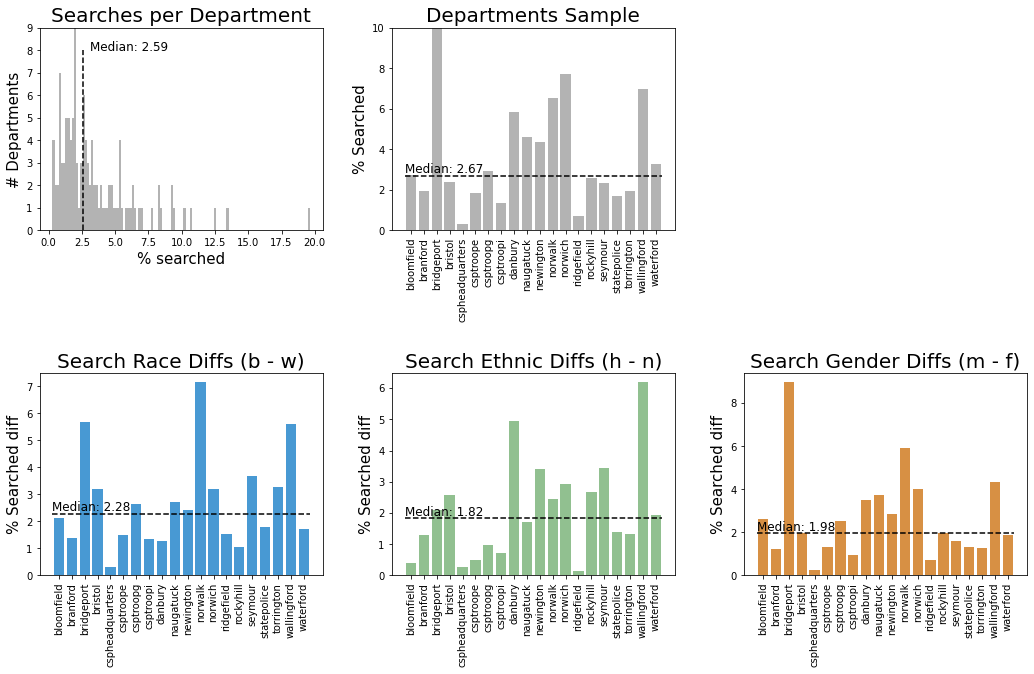

In [13]:
# Get and plot biases per selected departments

## Get and organize data to plot

#select top 55 depts
top_dpts = dpt_names[0:x_vline+1]
#select 'statepolice' dept
dpts_sample = [top_dpts[0]]
#randomly select 19 more depts
dpts_sample.extend(sample(top_dpts[1:],19))


#df grouped by department

dpts_obs = fair_df.groupby("Department Name")['Department Name'].count()
dpts_src = fair_df[fair_df['Vehicle Searched Indicator']==True].groupby('Department Name')['Department Name'].count()
dpts_prop = dpts_src / dpts_obs * 100


#selected departments

select_obs = dpts_obs[dpts_obs.index.isin(dpts_sample)].copy()
select_src = dpts_src[dpts_src.index.isin(dpts_sample)].copy()
select_prop = select_src / select_obs * 100
select_labels = select_obs.index.tolist()


#searches per race

select_df = fair_df[fair_df["Department Name"].isin(dpts_sample)].copy()
race_obs = select_df.groupby(["Department Name","Subject Race Code"])['Subject Race Code'].count()
race_src = select_df[select_df['Vehicle Searched Indicator']==True].groupby(["Department Name","Subject Race Code"])['Subject Race Code'].count()
race_props = race_src / race_obs * 100
race_diff = np.array(race_props[race_props.index.get_level_values(1)=='b']) - np.array(race_props[race_props.index.get_level_values(1)=='w'])
race_labels = race_obs.index.get_level_values(0).tolist()


#searches per ethnic group

ethnic_obs = select_df.groupby(["Department Name","Subject Ethnicity Code"])['Subject Ethnicity Code'].count()
ethnic_src = select_df[select_df['Vehicle Searched Indicator']==True].groupby(["Department Name","Subject Ethnicity Code"])['Subject Race Code'].count()
ethnic_props = ethnic_src / ethnic_obs * 100
ethnic_diff = np.array(ethnic_props[ethnic_props.index.get_level_values(1)=='h']) - np.array(ethnic_props[ethnic_props.index.get_level_values(1)=='n'])
ethnic_labels = ethnic_obs.index.get_level_values(0).tolist()


#searches per gender group

gender_obs = select_df.groupby(["Department Name","Subject Sex Code"])['Subject Sex Code'].count()
gender_src = select_df[select_df['Vehicle Searched Indicator']==True].groupby(["Department Name","Subject Sex Code"])['Subject Sex Code'].count()
gender_props = gender_src / gender_obs * 100
gender_diff = np.array(gender_props[gender_props.index.get_level_values(1)=='m']) - np.array(gender_props[gender_props.index.get_level_values(1)=='f'])
gender_labels = gender_obs.index.get_level_values(0).tolist()
       

#define fig and subplots
fig,axs = plt.subplots(2, 3, figsize=(15,10))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12


## Plot

#plot searches per department
axs[0,0].hist(dpts_prop,120,color = '#B3B3B3')
axs[0,0].plot([dpts_prop.median(), dpts_prop.median()],[0,8], linestyle = '--',color = 'k')
axs[0,0].text(dpts_prop.median()+0.5, 8,'Median: ' + str(np.round(dpts_prop.median(),2)),fontsize = txt_font,color = 'k')
axs[0,0].set_xlabel('% searched',fontsize = l_font)
axs[0,0].set_ylabel('# Departments',fontsize = l_font)
axs[0,0].set_title('Searches per Department',fontsize = t_font)
axs[0,0].set_ylim([0, 9])
 
#plot searches per departments sample
axs[0,1].bar(select_labels,select_prop,color='#B3B3B3')
axs[0,1].plot([-0.5, 20-0.5],[select_prop.median(), select_prop.median()], linestyle = '--', color = 'k')
axs[0,1].text(-0.5, select_prop.median()+0.2,'Median: ' + str(np.round(select_prop.median(),2)),fontsize = txt_font,color = 'k')
axs[0,1].set_ylabel('% Searched',fontsize = l_font)
axs[0,1].set_title('Departments Sample',fontsize = t_font)
axs[0,1].set_ylim([0, 10])
axs[0,1].set_xticklabels(select_labels, rotation=90)

#empty axis
axs[0,2].axis("off")

#plot race search differences
axs[1,0].bar(select_labels,race_diff,color='#4899D3')
axs[1,0].plot([-0.5, 20-0.5],[np.median(race_diff), np.median(race_diff)], linestyle = '--', color = 'k')
axs[1,0].text(-0.5, np.median(race_diff)+0.1,'Median: ' + str(np.round(np.median(race_diff),2)),fontsize = txt_font,color = 'k')
axs[1,0].set_ylabel('# Departments',fontsize = l_font)
axs[1,0].set_ylabel('% Searched diff',fontsize = l_font)
axs[1,0].set_title('Search Race Diffs (b - w)',fontsize = t_font)
axs[1,0].set_xticklabels(select_labels, rotation=90)

#plot ethnicity search differences
axs[1,1].bar(select_labels,ethnic_diff,color = '#91C090')
axs[1,1].plot([-0.5, 20-0.5],[np.median(ethnic_diff), np.median(ethnic_diff)], linestyle = '--', color = 'k')
axs[1,1].text(-0.5, np.median(ethnic_diff)+0.1,'Median: ' + str(np.round(np.median(ethnic_diff),2)),fontsize = txt_font,color = 'k')
axs[1,1].set_ylabel('% Searched diff',fontsize = l_font)
axs[1,1].set_title('Search Ethnic Diffs (h - n)',fontsize = t_font)
axs[1,1].set_xticklabels(select_labels, rotation=90)

#plot gender search differences
axs[1,2].bar(select_labels,gender_diff,color = '#D79044')
axs[1,2].plot([-0.5, 20-0.5],[np.median(gender_diff), np.median(gender_diff)], linestyle = '--', color = 'k')
axs[1,2].text(-0.5, np.median(gender_diff)+0.1,'Median: ' + str(np.round(np.median(gender_diff),2)),fontsize = txt_font,color = 'k')
axs[1,2].set_ylabel('% Searched diff',fontsize = l_font)
axs[1,2].set_title('Search Gender Diffs (m - f)',fontsize = t_font)
axs[1,2].set_xticklabels(select_labels, rotation=90)

fig.tight_layout(pad=3.0)

plt.show()


## Biases per department results

The percentage of vehicles searched distribution is right skewed, with a median value of 2.59% (top left). On center top we can see that the percentages of searched vehicles per department, and correspondent median, for our selected sample is consistent.

The bottom plots confirm that the differences in searches between the groups of each protected class, seen in the general results, are pretty much replicated in the departments present in our sample.

These again allows us to confirm the presence of clear biases agains specific groups within the three protected classes. 